In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../../azimuth.env")

# Add PATH_ROOT to Python path
import sys
sys.path.append(os.getenv("PATH_ROOT"))

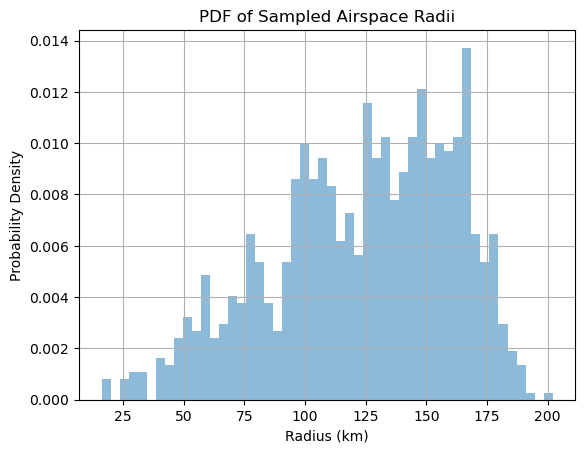

In [2]:
# Testing airspace radius sampling

import MARTINI.airspace.randomize_airspace as randomize_airspace
import matplotlib.pyplot as plt
radii = randomize_airspace.sample_airspace_radius(500, beta=3.0, N=1_000)

# Plot histogram of radii as PDF
plt.hist(radii, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
plt.xlabel('Radius (km)')
plt.ylabel('Probability Density')
plt.title('PDF of Sampled Airspace Radii')
plt.grid(True)
plt.show()


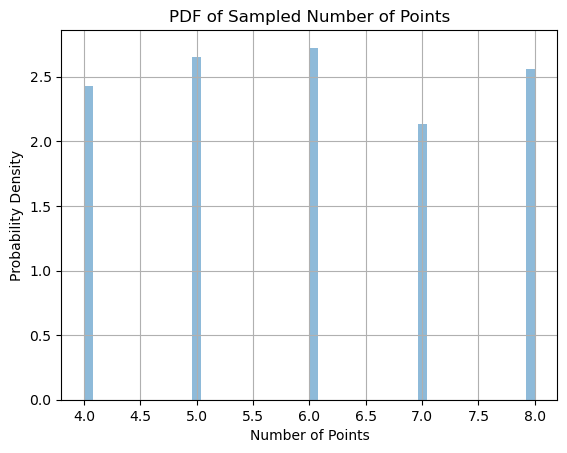

In [3]:
# Testing the number of points for the polygon

num_points = randomize_airspace.get_num_points_of_airspace(n_min=4, n_max=8)

# Plot histogram of number of points as PDF
plt.hist(num_points, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
plt.xlabel('Number of Points')
plt.ylabel('Probability Density')
plt.title('PDF of Sampled Number of Points')
plt.grid(True)
plt.show()


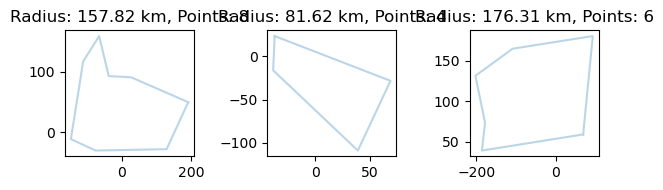

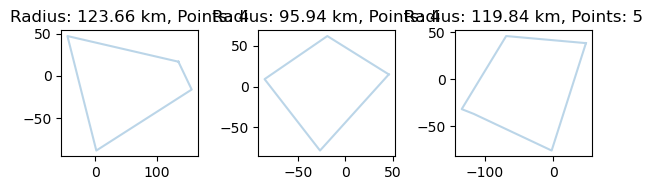

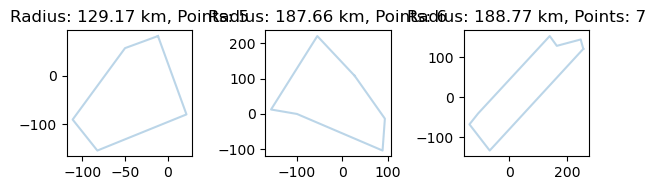

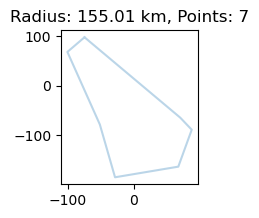

In [4]:
# Testing the unit polygon

import numpy as np

for i in range(10):
    radius = radii[i]
    n_points = num_points[i]

    # Create subplot grid with 3 columns
    if i % 3 == 0:
        fig = plt.figure(figsize=(6, 2))
    
    plt.subplot(1, 3, (i % 3) + 1)
    polygon, area = randomize_airspace.generate_unit_polygon(n_points, radius)
    plt.plot(np.append(polygon[:, 0], polygon[0, 0]), 
             np.append(polygon[:, 1], polygon[0, 1]), 
             alpha=0.3)
    plt.title(f'Radius: {radius:.2f} km, Points: {n_points}')
    
    # Close figure after every 3rd plot
    if i % 3 == 2:
        plt.tight_layout()



There are 10 parents generated
There are 17 entries generated


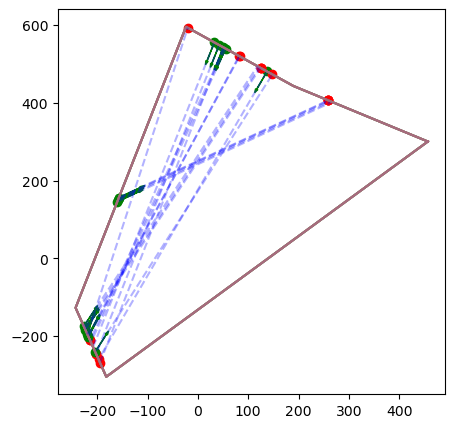

In [79]:
# Testing Thomas-Jensen Transit Process

import MARTINI.arrivals.thomas as thomas
import MARTINI.airspace.geo as geo
import MARTINI.airspace.intersect as intersect

# Generate a polygon
polygon, area = randomize_airspace.generate_unit_polygon(5, 500, seed=69420)

# Disable random seed
np.random.seed(None)

# Generate points
random_points, parent_indices, edge_points, transit_length = thomas.thomas_jensen_process(polygon, lambda_parent=8e-3, mu=2, sigma=12, min_transit_length=96, min_dist_to_vertex=42)
# Find the exit points for each parent
exit_points, velocity_vectors = thomas.get_exit_point_for_parent(polygon, random_points, parent_indices)

print(f'There are {np.unique(parent_indices).shape[0]} parents generated')
print(f'There are {len(random_points)} entries generated')
# If there are no points, skip
if len(random_points) == 0:
    print("No points generated")

trajectory_count = 0


plt.figure(figsize=(5,5))

# Plot the entry points
for i, point in enumerate(random_points):
    # Scatter the entry points
    plt.scatter(point[0], point[1], color='green')

    # Plot the polygon
    plt.plot(np.append(polygon[:, 0], polygon[0, 0]), 
                np.append(polygon[:, 1], polygon[0, 1]), 
                alpha=0.3)
    
    edge = edge_points[i]

    # Get parent index for this entry point
    parent_idx = parent_indices[i]
    parent_indices_unique = np.unique(np.array(parent_indices))
    parent_idx = np.where(parent_indices_unique == parent_idx)[0][0]
    # Get corresponding velocity vector
    velocity = velocity_vectors[parent_idx]

    # Scatter the exit point
    plt.scatter(exit_points[parent_idx][0], exit_points[parent_idx][1], color='red')
    
    # intersection = geo.find_line_polygon_intersection(point, velocity, polygon)
    intersection, valid_path = intersect.find_intersection(polygon, velocity, point)
    if intersection is not None and valid_path:
        # Plot the trajectory
        plt.plot([point[0], intersection[0]], [point[1], intersection[1]],
                'b--', alpha=0.3)
        # Scatter plot the intersection
        # plt.scatter(intersection[0], intersection[1], color='blue')
        trajectory_count += 1
    else:
        print(f'No intersection found for point {i}')

    # Arrow the velocity vector
    plt.arrow(point[0], point[1], 
            velocity[0]*50, velocity[1]*50,  # Scale velocity for visibility
            head_width=5, head_length=10, 
            fc='blue', ec='green', alpha=1.)

# Visualize
# thomas.visualize_entry_points(polygon, random_points)